In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [3]:
df = pd.read_csv("../dataset/Loan_Default.csv")
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [5]:
n_unique_values = 10
all_columns = df.columns.to_list()
categorical_columns = []

for i, column in enumerate(all_columns):
    temp = df.loc[:, column].unique()
    if len(temp) < n_unique_values:
        print (f"{i+1}. {column} has {len(temp)} unique values, which are {temp}")
        categorical_columns.append(column)
del temp

2. year has 1 unique values, which are [2019]
3. loan_limit has 3 unique values, which are ['cf' nan 'ncf']
4. Gender has 4 unique values, which are ['Sex Not Available' 'Male' 'Joint' 'Female']
5. approv_in_adv has 3 unique values, which are ['nopre' 'pre' nan]
6. loan_type has 3 unique values, which are ['type1' 'type2' 'type3']
7. loan_purpose has 5 unique values, which are ['p1' 'p4' 'p3' 'p2' nan]
8. Credit_Worthiness has 2 unique values, which are ['l1' 'l2']
9. open_credit has 2 unique values, which are ['nopc' 'opc']
10. business_or_commercial has 2 unique values, which are ['nob/c' 'b/c']
16. Neg_ammortization has 3 unique values, which are ['not_neg' 'neg_amm' nan]
17. interest_only has 2 unique values, which are ['not_int' 'int_only']
18. lump_sum_payment has 2 unique values, which are ['not_lpsm' 'lpsm']
20. construction_type has 2 unique values, which are ['sb' 'mh']
21. occupancy_type has 3 unique values, which are ['pr' 'sr' 'ir']
22. Secured_by has 2 unique values, whic

In [6]:
df['Gender'] = df['Gender'].replace("Sex Not Available", np.nan)

In [7]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
missing_columns

['loan_limit',
 'Gender',
 'approv_in_adv',
 'loan_purpose',
 'rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'Neg_ammortization',
 'property_value',
 'income',
 'age',
 'submission_of_application',
 'LTV',
 'dtir1']

In [8]:
def get_missing_percent(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

missing_percent = get_missing_percent(df)

loan_limit : 3344 (2.249%)
Gender : 37659 (25.331%)
approv_in_adv : 908 (0.611%)
loan_purpose : 134 (0.09%)
rate_of_interest : 36439 (24.51%)
Interest_rate_spread : 36639 (24.645%)
Upfront_charges : 39642 (26.664%)
term : 41 (0.028%)
Neg_ammortization : 121 (0.081%)
property_value : 15098 (10.155%)
income : 9150 (6.155%)
age : 200 (0.135%)
submission_of_application : 200 (0.135%)
LTV : 15098 (10.155%)
dtir1 : 24121 (16.225%)


In [9]:
property_value_LTV_missing_correl = 0
interest_upfront_missing_correl = 0
for ind in df.index:
    if pd.isna(df['property_value'][ind]) and pd.isna(df['LTV'][ind]):
        property_value_LTV_missing_correl += 1
    if pd.isna(df['rate_of_interest'][ind]) and pd.isna(df['Interest_rate_spread'][ind]) and pd.isna(df['Upfront_charges'][ind]):
        interest_upfront_missing_correl += 1
print(property_value_LTV_missing_correl)
print(interest_upfront_missing_correl)
    

15098
36439


In [10]:
gender_interest_upfront_missing_correl = 0
for ind in df.index:
    if pd.isna(df['rate_of_interest'][ind]) and pd.isna(df['Interest_rate_spread'][ind]) and pd.isna(df['Upfront_charges'][ind]) and pd.isna(df['Gender'][ind]):
        gender_interest_upfront_missing_correl += 1
print(gender_interest_upfront_missing_correl)

10567


In [11]:
df['Gender'].unique()

array([nan, 'Male', 'Joint', 'Female'], dtype=object)

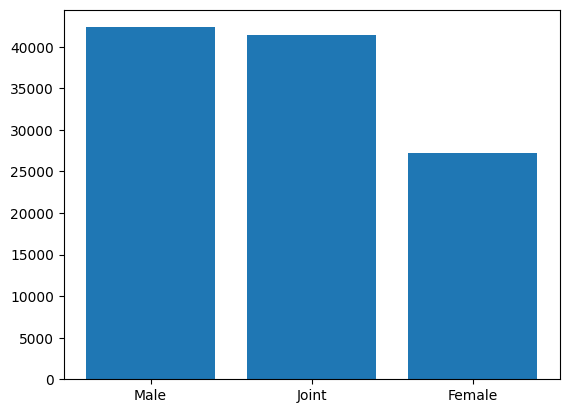

In [12]:
def gender_graph(df):
    df_copy = df['Gender'].copy()
    gender_freq = df_copy.value_counts()
    plt.bar(gender_freq.index, gender_freq.values)
    plt.show()
gender_graph(df)

In [13]:
df['Gender']

0            NaN
1           Male
2           Male
3           Male
4          Joint
           ...  
148665       NaN
148666      Male
148667      Male
148668    Female
148669    Female
Name: Gender, Length: 148670, dtype: object

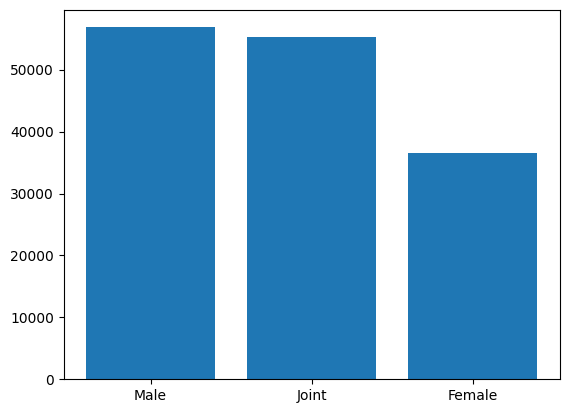

0           Male
1           Male
2           Male
3           Male
4          Joint
           ...  
148665      Male
148666      Male
148667      Male
148668    Female
148669    Female
Name: Gender, Length: 148670, dtype: object

In [14]:
df['Gender'].fillna(method="bfill", inplace=True)
gender_graph(df)
df['Gender']

In [15]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
missing_columns


['loan_limit',
 'approv_in_adv',
 'loan_purpose',
 'rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'Neg_ammortization',
 'property_value',
 'income',
 'age',
 'submission_of_application',
 'LTV',
 'dtir1']

In [16]:
cat_missing_cols = [col for col in missing_columns if df[col].dtype == 'object']
cat_missing_cols


['loan_limit',
 'approv_in_adv',
 'loan_purpose',
 'Neg_ammortization',
 'age',
 'submission_of_application']

In [17]:
for col in cat_missing_cols:
    df[col].fillna(method="ffill", inplace=True)
    df[col].fillna(method="bfill", inplace=True)
    print(df[col].isna().sum())

0
0
0
0
0
0


In [18]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
for col in missing_columns:
    print(df[col].dtype)

float64
float64
float64
float64
float64
float64
float64
float64


In [19]:
knn = KNNImputer(n_neighbors = 3)
df_temp = df[missing_columns]
knn.fit(df_temp)
X = knn.transform(df_temp)
df_temp = pd.DataFrame(X, columns = missing_columns)

In [20]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rate_of_interest      148670 non-null  float64
 1   Interest_rate_spread  148670 non-null  float64
 2   Upfront_charges       148670 non-null  float64
 3   term                  148670 non-null  float64
 4   property_value        148670 non-null  float64
 5   income                148670 non-null  float64
 6   LTV                   148670 non-null  float64
 7   dtir1                 148670 non-null  float64
dtypes: float64(8)
memory usage: 9.1 MB


In [21]:
for col in missing_columns:
    df[col] = df_temp[col]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 148670 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              148670 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148670 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           148670 non-null  float64
 12  Interest_rate_spread       148670 non-null  float64
 13  Upfront_charges            14

In [22]:
num_cols = [col for col in df.columns if df[col].dtype != 'object']
num_cols

['ID',
 'year',
 'loan_amount',
 'rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'property_value',
 'income',
 'Credit_Score',
 'LTV',
 'Status',
 'dtir1']

In [23]:
for col in num_cols:
    print("{} {} ".format(col, df[col].nunique()))

ID 148670 
year 1 
loan_amount 211 
rate_of_interest 462 
Interest_rate_spread 29754 
Upfront_charges 67288 
term 29 
property_value 504 
income 1217 
Credit_Score 401 
LTV 9129 
Status 2 
dtir1 147 


In [24]:
num_cols.remove('ID')
num_cols.remove('year')
num_cols.remove('term')
num_cols.remove('Status')

In [25]:
df_temp = df.copy()
for col in num_cols:
    q1 = df_temp[col].quantile(0.25)
    q3 = df_temp[col].quantile(0.75)
    IQR = q3-q1
    lower = q1-3*IQR
    upper = q3+3*IQR
    df_temp = df_temp[(df_temp[col] < upper) & (df_temp[col] > lower)]
    
dropped = len(df) - len(df_temp)
proportion_remaining = round(len(df_temp) / len(df), 5)
proportion_dropped = round(1 - proportion_remaining, 2) * 100
print(dropped, ' redova izbaceno')
print(proportion_dropped, "% originalnog dataset-a" )
df = df_temp

5757  redova izbaceno
4.0 % originalnog dataset-a


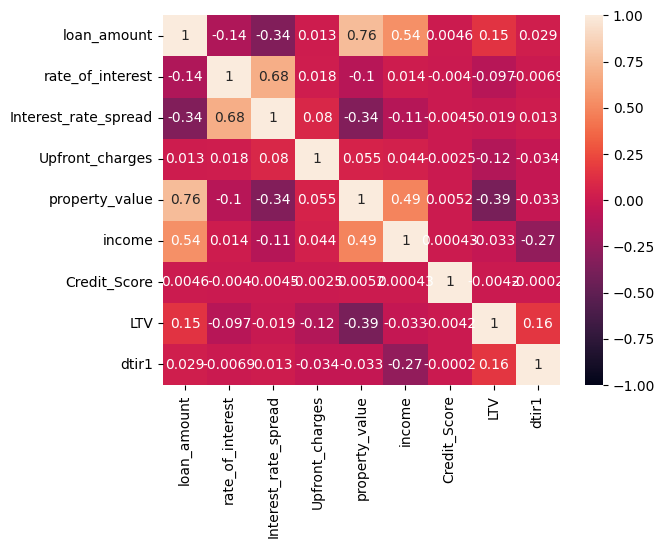

In [26]:
corr = df[num_cols].corr()
import seaborn as sns
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

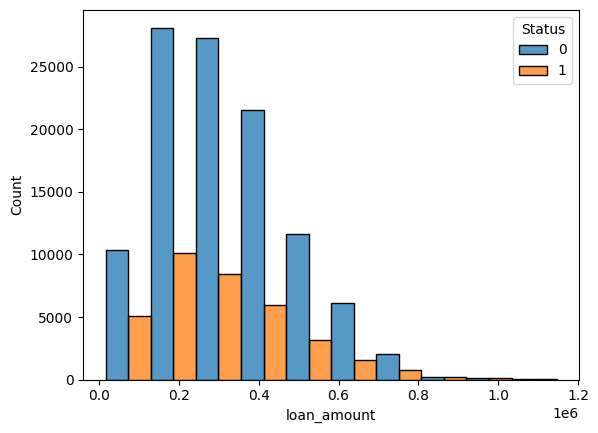

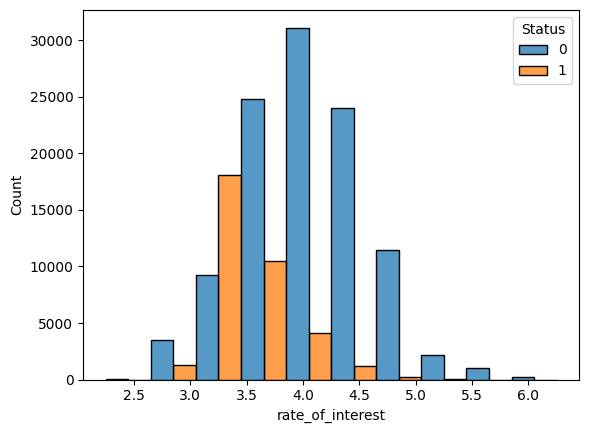

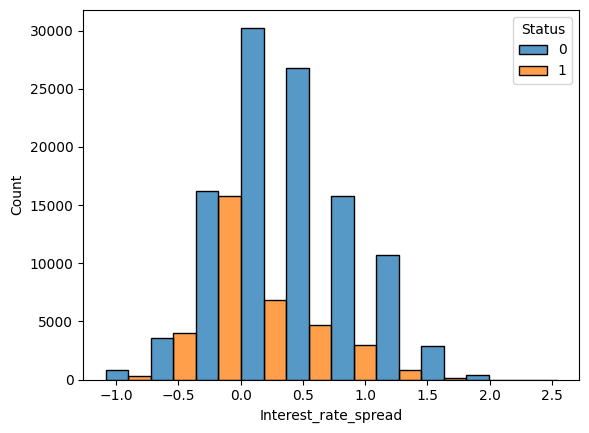

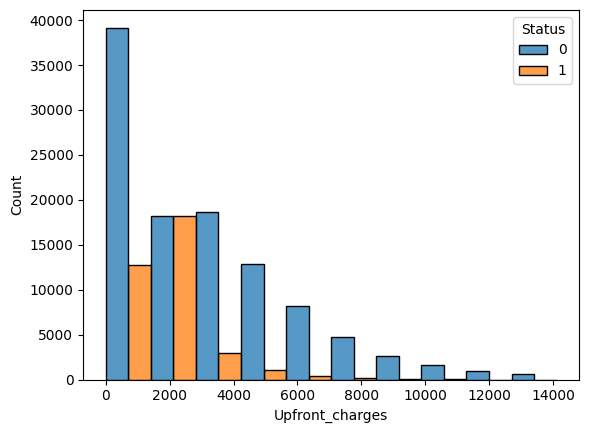

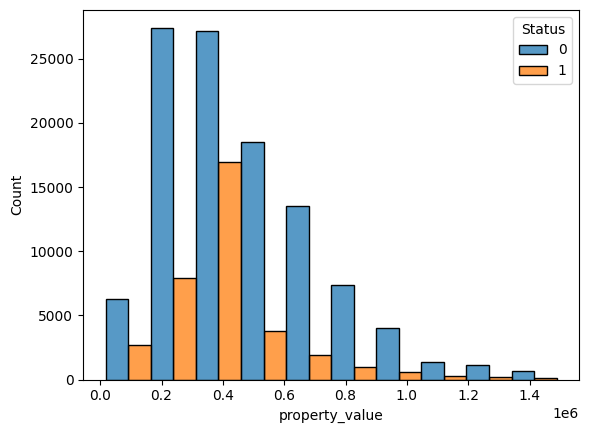

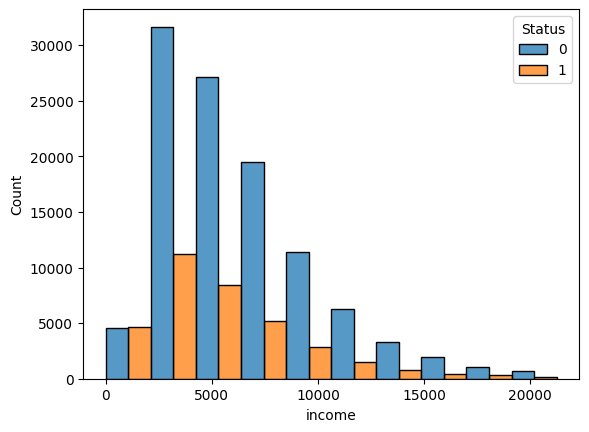

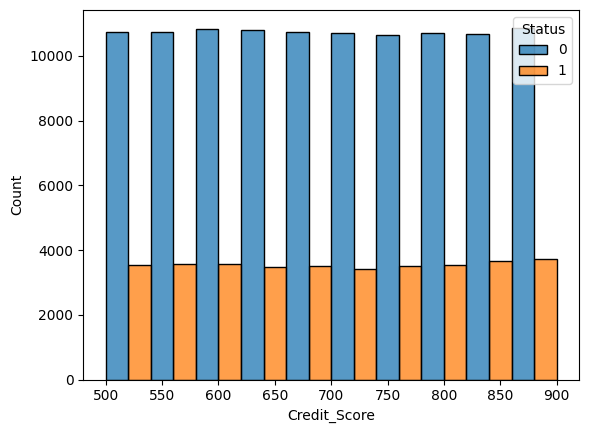

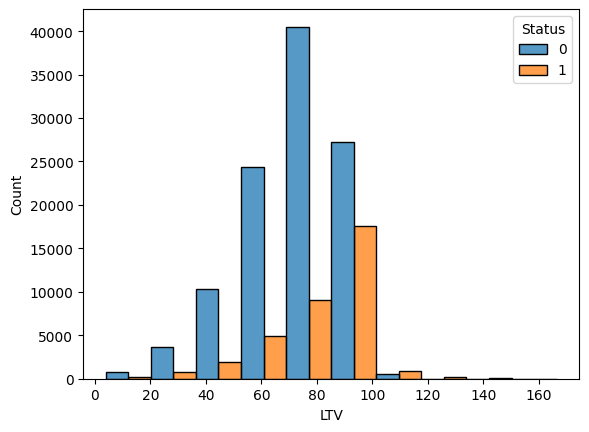

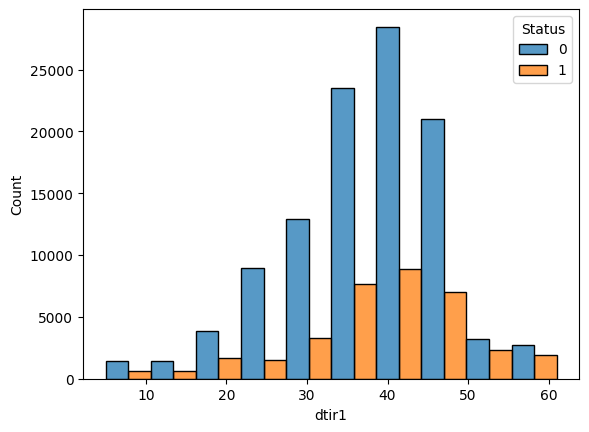

In [27]:
for col in num_cols:
    sns.histplot(data=df, x=col, hue='Status', multiple="dodge", bins=10)
    plt.show()

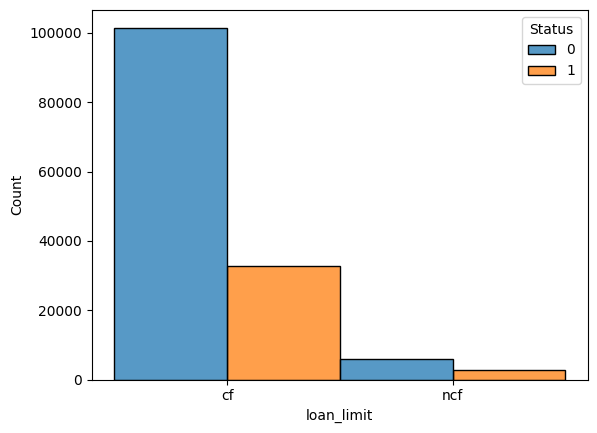

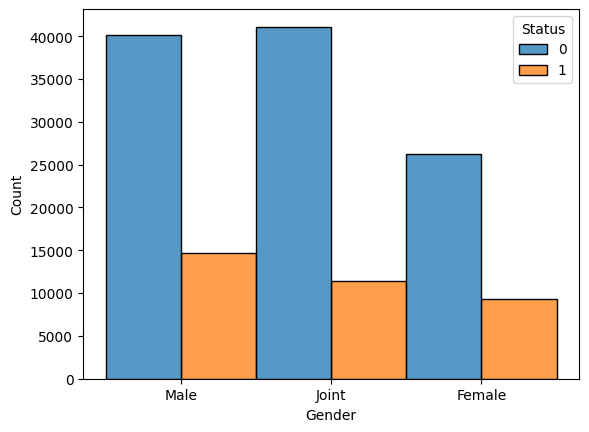

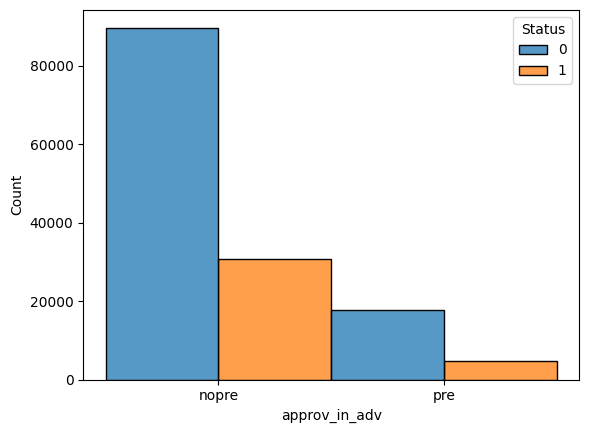

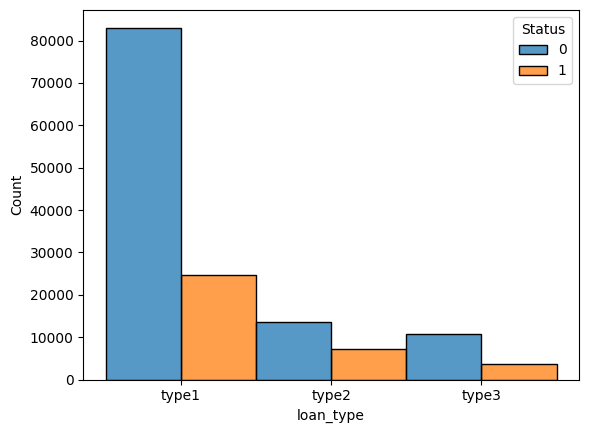

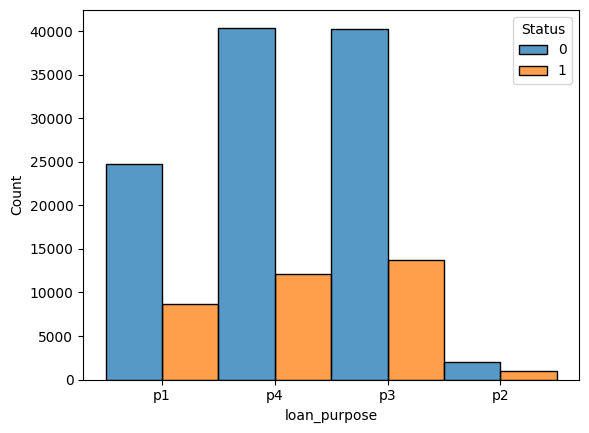

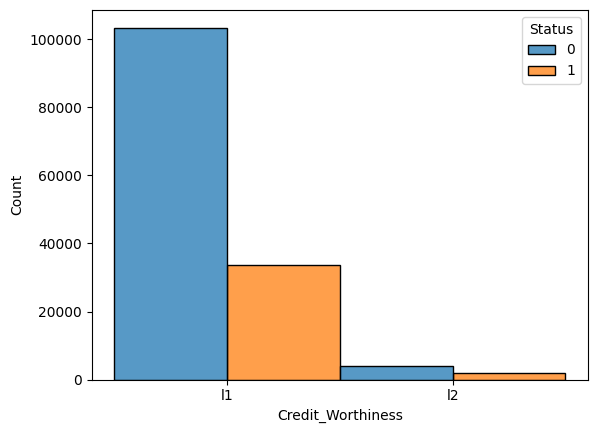

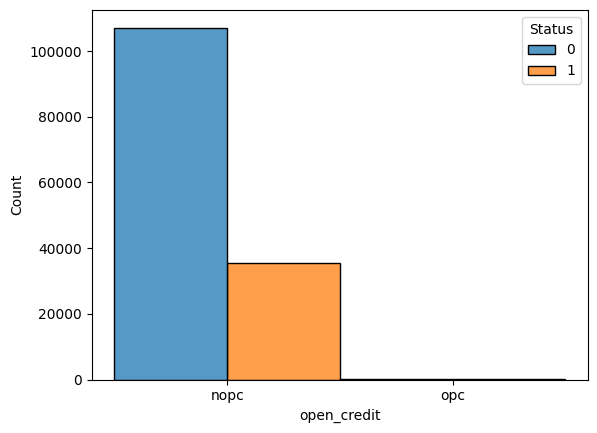

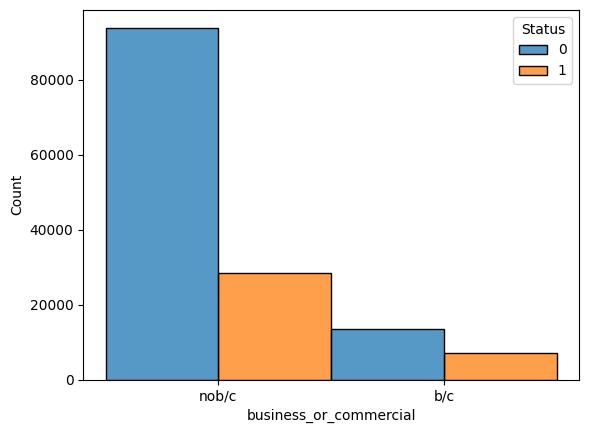

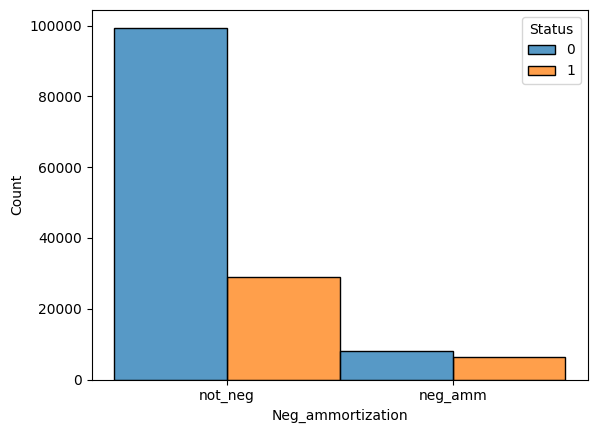

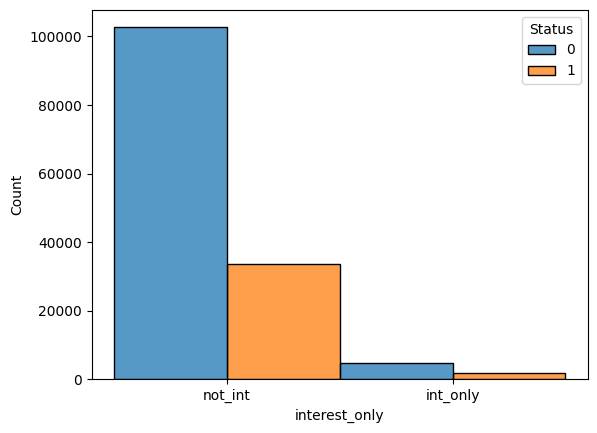

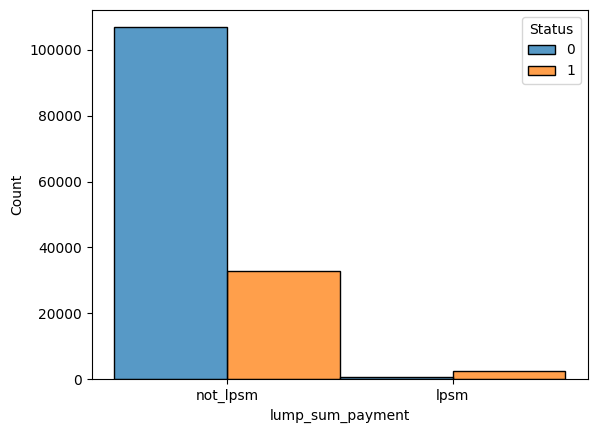

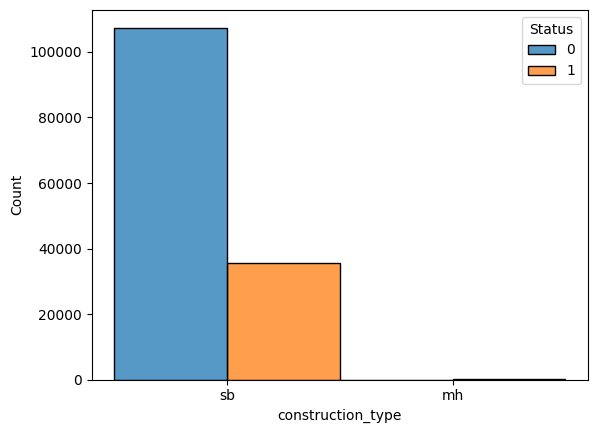

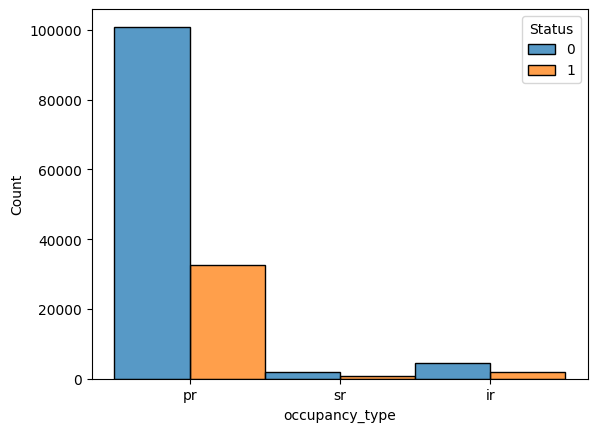

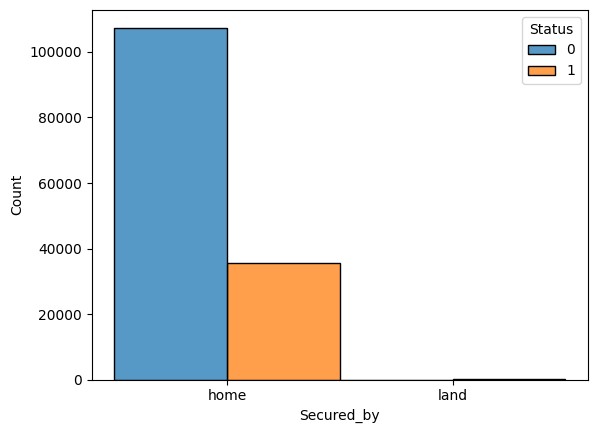

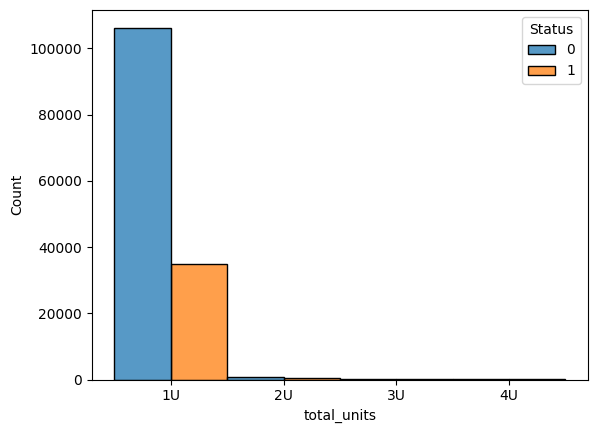

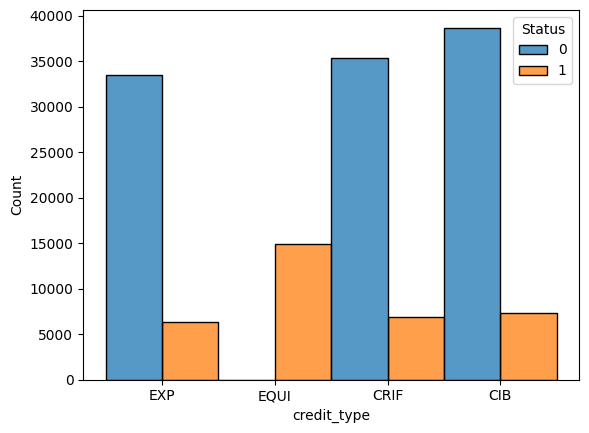

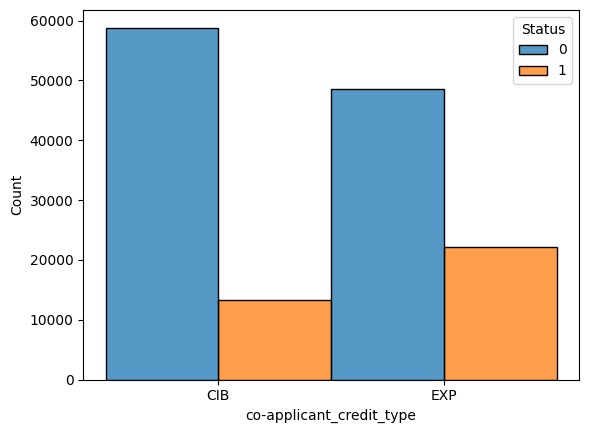

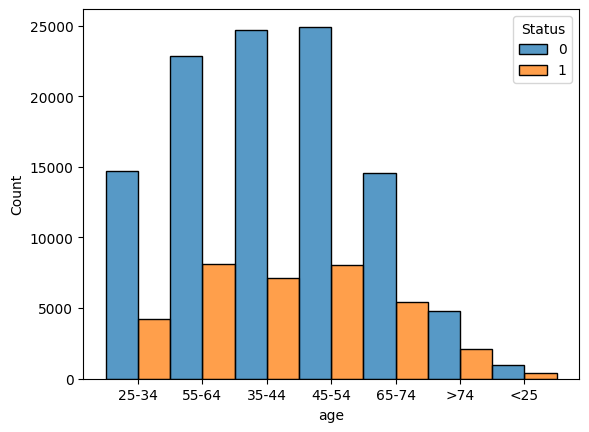

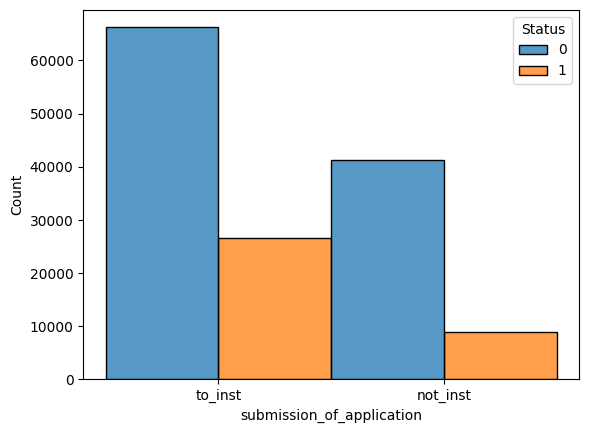

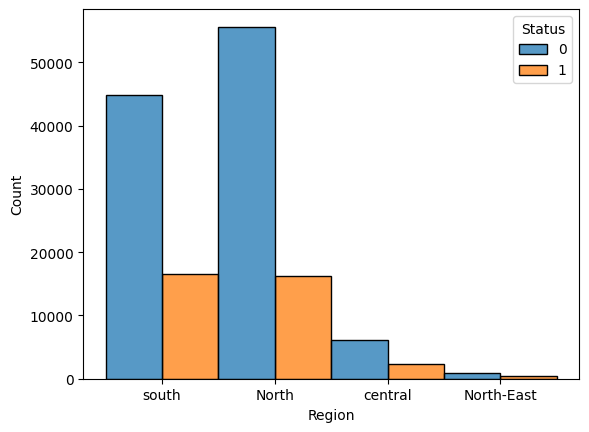

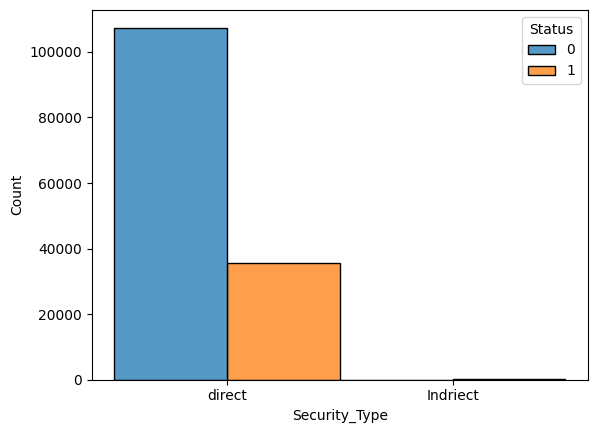

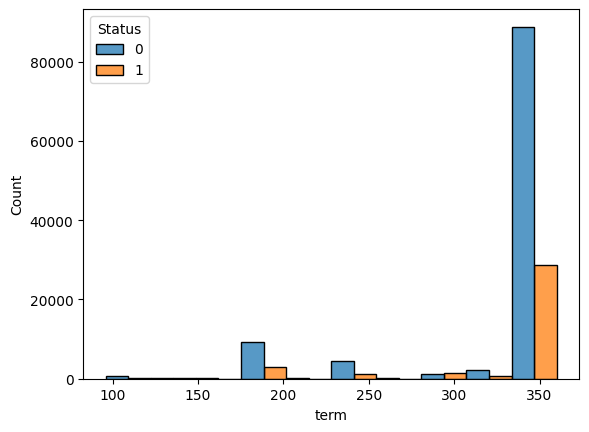

In [28]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
cat_cols.append('term')
for col in cat_cols:
    sns.histplot(data=df, x=col, hue='Status', multiple="dodge", bins=10)
    plt.show()

In [29]:
from sklearn.model_selection import train_test_split

X = df.copy()
y = df['Status']

X = X.drop(columns=['Status'])
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X


,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,property_value,income,Credit_Score,LTV,...,term_280.0,term_288.0,term_300.0,term_312.0,term_320.0,term_322.0,term_324.0,term_336.0,term_348.0,term_360.0
0,24890,2019,116500,3.288333,-0.299233,1752.116667,118000.0,1740.0,758,98.728814,...,False,False,False,False,False,False,False,False,False,True
1,24891,2019,206500,3.705000,0.023400,700.543333,388000.0,4980.0,552,86.500944,...,False,False,False,False,False,False,False,False,False,True
2,24892,2019,406500,4.560000,0.200000,595.000000,508000.0,9480.0,834,80.019685,...,False,False,False,False,False,False,False,False,False,True
3,24893,2019,456500,4.250000,0.681000,2273.626667,658000.0,11880.0,587,69.376900,...,False,False,False,False,False,False,False,False,False,True
4,24894,2019,696500,4.000000,0.304200,0.000000,758000.0,10440.0,602,91.886544,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,173555,2019,436500,3.125000,0.257100,9960.000000,608000.0,7860.0,659,71.792763,...,False,False,False,False,False,False,False,False,False,False
148666,173556,2019,586500,5.190000,0.854400,0.000000,788000.0,7140.0,569,74.428934,...,False,False,False,False,False,False,False,False,False,True
148667,173557,2019,446500,3.125000,0.081600,1226.640000,728000.0,6900.0,702,61.332418,...,False,False,False,False,False,False,False,False,False,False
148668,173558,2019,196500,3.500000,0.582400,4323.330000,278000.0,7140.0,737,70.683453,...,False,False,False,False,False,False,False,False,False,False


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [31]:
from joblib import dump
dump((X_train, X_test, y_train, y_test), 'classification_data.joblib')

['classification_data.joblib']

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(data=X_scaled, columns=X.columns)
dump((X, y), 'clustering_data.joblib')

['clustering_data.joblib']